In [1]:
using PyPlot, LinearAlgebra, Random, Distributions

In [2]:
ROOM_LEN = 2.2        # Width and height of environment (meters)
PERIMETER_DIST = 0.03 # Perimeter region distance to walls (meters)
σv = 0.13            # Forward velocity Rayleigh distribution scale (m/sec)
μω = 0.0            # Rotation velocity Gaussian distribution mean (rad/sec)
σω = (330 / 360) * 2π # Rotation velocity Gaussian distribution standard deviation (rad/sec)
Δt = 0.02            # Simulation-step time increment (seconds)
ρdecel = 0.75;       # Velocity reduction factor when located in the perimeter

In [3]:
wrap(x) = mod(x, 2π); # limit 0~2π angle

In [4]:
println("% : ", -1 % 2, ", rem : ", rem(-1, 2), ", mod : ", mod(-1, 2))

% : -1, rem : -1, mod : 1


In [5]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngleSquare(pos, θ)
    if pos[1] < PERIMETER_DIST
        dWall, aWall = pos[1], θ + π
    elseif pos[2] < PERIMETER_DIST
        dWall, aWall = pos[2], θ + 1.5π
    elseif pos[1] > ROOM_LEN - PERIMETER_DIST
        dWall, aWall = ROOM_LEN - pos[1], θ
    elseif pos[2] > ROOM_LEN - PERIMETER_DIST
        dWall, aWall = ROOM_LEN - pos[2], θ + 0.5π
    else
        dWall, aWall = 3.0, 0.0
    end
    aWall = wrap(aWall)
    return dWall, aWall
end;

In [6]:
function generateRatTrajectory(num_steps)
    # store arrays
    Position, Velocity = zeros(num_steps, 2), zeros(num_steps, 2)
    Speed, θ = zeros(num_steps), zeros(num_steps) # Forward speed, head direction

    # initial values
    θ[1], Speed[1] = rand() * 2π, 0
    Position[1, :] = clamp.(rand(2) * ROOM_LEN, -0.1, ROOM_LEN-0.1)
    Velocity[1, :] = Speed[1] * [sin(θ[1]), cos(θ[1])]
    
    # iteration of trajectory
    for i in 1:num_steps-1
        dWall, aWall = minDistAngleSquare(Position[i, :], θ[i])
        if (dWall < PERIMETER_DIST) && (0 < aWall < π)
            Speed[i+1] = ρdecel * Speed[i] # deceleration
            θ[i+1] = wrap(θ[i] + sign(aWall) * (π/2 - abs(aWall)) + (μω + randn()*σω)) # turn, 
        else
            Speed[i+1] = rand(Rayleigh(σv))
            θ[i+1] = wrap(θ[i] + (μω + randn()*σω) * Δt)
        end
        Position[i+1, :] = Position[i, :] + Velocity[i, :] * Δt
        Velocity[i+1, :] = Speed[i+1] * [sin(θ[i+1]), cos(θ[i+1])]
    end
    return Position, Velocity, Speed, θ
end;

In [7]:
num_timesteps = 50000
Position, Velocity, Speed, θ =  generateRatTrajectory(num_timesteps);

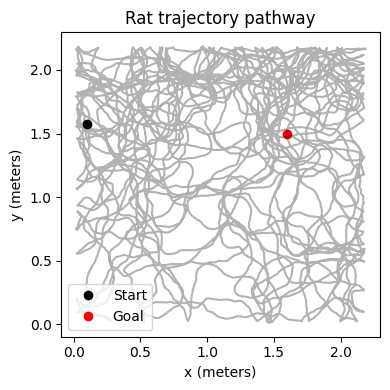

In [8]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
xlabel("x (meters)"); ylabel("y (meters)")
#xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(Position[1, 1], Position[1, 2], "ko", label="Start")
plot(Position[end, 1], Position[end, 2], "ro", label="Goal")
plot(Position[:, 1], Position[:, 2], color="k", alpha=0.3)
legend()
tight_layout()